<!--Header-->
<div>
    <div class="row" style="color: #4D4D4D;font-size: 15px;padding-bottom: 20px">
        <div class="col-md-7">
            <img src="https://cv.uoc.edu/mc-icons/inici/logoUOC.png" alt="Logo UOC" class="img-responsive" style="margin:20px 0px 0px">
        </div>
        <div class="col-md-5">
            <h1 style="margin:15px 0px 0px;font-size: 40px;">Avaluació de models de classificació</h1>
            <div style="text-align:left;margin-top: 5px;"></div>
        </div>
    </div>
    <div class="row" style="background: #FCB517;padding: 10px 20px;">
        <div class="col-md-6">
            <div>PID_00233252</div>
        </div>
        <div class="col-md-6">
            <div style="text-align:right;">Autor: Xavier Duran Albareda <span style="margin-left: 30px;">Coordinació: Julià Minguillón</span></div>
        </div>
    </div>
</div>
<!--/Header-->

## Introducció

Els problemes de classificació són un dels més comuns dins de l'aprenentatge automàtic. Es tracta d'un aprenentatge supervisat, és a dir, algorismes que a partir d'un conjunt de dades etiquetades generalitzen un model que faci una predicció el més acurada possible de l'etiqueta en un nou conjunt de dades del mateix tipus.

![ML](images/ml_algorithms.jpeg)

En aquesta activitat ens centrarem en mostrar diferents mesures que podem fer servir per avaluar un model de classificació.

## Titanic

El conjunt de dades que farem servir correspon al dataset de la competició [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) de [Kaggle](https://www.kaggle.com/). El conjunt de dades l'hem preparat prèviament i ja està net, sense dades no disponibles i a punt per analitzar.

In [1]:
import numpy as np
import pandas as pd

titanic_clean = pd.read_csv('data/titanic_clean.csv', header = 0)
titanic_clean.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1


### Descripció de les dades

La variable _Survived_ és la que volem predir amb el nostre classificador, i només té dues categories: 0 i 1 segons la persona va sobreviure a la catàstrofe o no.

Les variables independents que ens serviran de predictors en el nostre model són les següents:

- _Pclass_: la classe de tiquet (1a, 2a o 3a categoria)
- _Sex_: El sexe del passatger (0 correspon a femení; 1 a masculí)
- _Age_: Edat del passatger categoritzada en 5 rangs d'edat:
  - 0 correspon al rang de 0 a 16 anys
  - 1 correspon al rang de 16 a 32 anys
  - 2 correspon al rang de 32 a 48 anys
  - 3 correspon al rang de 48 a 64 anys
  - 4 correspon a més de 64 anys
- _Fare_: Preu del passatge, categoritzat en 5 rangs, de més econòmic a més car
- _Embarked_: Port d'embarcament
- _IsAlone_: Si viatjava sola o no
- _Title_: Títol indicat amb el nom del passatger
  - 0 Master
  - 1 Miss
  - 2 Mr
  - 3 Mrs
  - 4 Rare

### Binarització de les variables categòriques

El model de regressió logística que farem servir com a classificador només funciona amb valors numèrics, i en el nostre _dataset_ tenim variables categòriques. Per convertir aquestes variables en numèriques, la manera més senzilla és fer el que es coneix per _one-hot encoding_, és a dir, transformar cada categoria de la variable en un vector binari que indiqui si la variable té aquest valor o no.

A continuació transformarem les variables categòriques _Pclass_, _Age_, _Fare_, _Embarked_ i _Title_ a binàries.

In [2]:
cols = ['Pclass']

titanic_categorical = titanic_clean[['Pclass', 'Age', 'Fare', 'Embarked', 'Title']]
titanic_categorical = pd.concat([pd.get_dummies(titanic_categorical[col], prefix=col) for col in titanic_categorical], axis=1)
df = pd.concat([titanic_clean[['Survived', 'Sex', 'IsAlone']], titanic_categorical], axis=1)
df.head()

,Survived,Sex,IsAlone,Pclass_1,Pclass_2,Pclass_3,Age_0,Age_1,Age_2,Age_3,...,Fare_2,Fare_3,Embarked_0,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5
0,0,1,0,False,False,True,False,True,False,False,...,False,False,True,False,False,True,False,False,False,False
1,1,0,0,True,False,False,False,False,True,False,...,False,True,False,True,False,False,False,True,False,False
2,1,0,1,False,False,True,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
3,1,0,0,True,False,False,False,False,True,False,...,False,True,True,False,False,False,False,True,False,False
4,0,1,1,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


### Conjunts d'entrenament i de prova

Abans de modelitzar les dades, en separarem una part per poder avaluar el model amb dades noves que no ha vist. Utilitzarem un 80% pel conjunt d'entrenament o _train_ i el 20% restant pel conjunt de prova o _test_.

![ML](images/ml.png)

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('Survived', axis=1)  # Specify axis parameter explicitly
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Model de regressió logística

Hi ha molts models de classificació diferents, i nosaltres en aquest exemple farem servir un model senzill: la regressió logística. El procés de mineria de dades és iteratiu i sovint, començar a analitzar les dades amb un model senzill que puguem avaluar i comprendre fàcilment ens dóna un bon punt de partida o _baseline_ per comparar-lo amb models més complexes en properes iteracions.

In [4]:
from sklearn import linear_model, datasets

logreg = linear_model.LogisticRegression()
model = logreg.fit(X_train, y_train)
model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### Prediccions del model

Un cop ja hem entrenat el model, realitzem les prediccions amb la funció `predict`.

In [5]:
predicted = model.predict(X_test)
predicted

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0])

## Mètriques per avaluar un model de classificació

Al llarg del temps s'han desenvolupat moltes mètriques per avaluar la qualitat d'aquests models de classificació, i fer-ne servir una o una altra dependrà molt de l'aplicació concreta que en vulguem fer. Un model serà bo si assigna correctament les etiquetes d'una classe a objectes que no s'han utilitzat per crear aquest model. 

### Matriu de confusió

La matriu de confusió és una manera senzilla de presentar els resultats d'un model de classificació amb dues o més classes. La taula mostra les prediccions a l'eix horitzontal i les etiquetes o resultats reals al vertical. El nombre que apareix en cadascun dels quadrants de la matriu correspon a les prediccions encertades, quan la predicció i la realitat ha coincidit; als falsos positius i els falsos negatius.

La relació entre falsos negatius i falsos positius és un equilibri en el que minimitzar-ne un implica maximitzar-ne l'altre. De manera que dependrà de l'aplicació què volem prioritzar. En una aplicació de control de seguretat, minimitzarem els falsos positius, ja que no volem que se'ns coli ningú no autoritzat. En altres casos, però, potser voldrem establir un equilibri.

<module 'matplotlib.pyplot' from '/Volumes/SanDisk/code/pcat/.conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

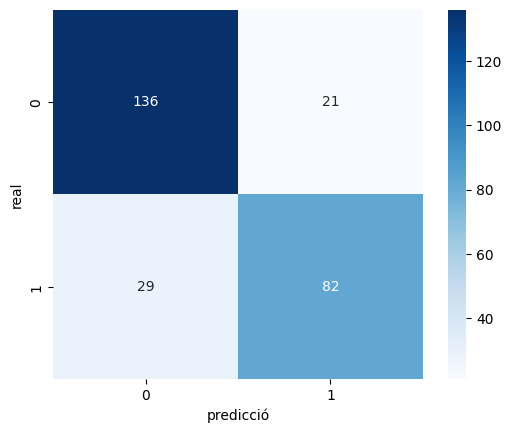

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predicted)
sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', square=True)
plt.xlabel("predicció")
plt.ylabel("real")
plt

El nostre model ha encertat 136 + 82 passatgers i n'ha classificat malament 21 + 29.

### Exactitud o _accuracy_

L'exactitud o _accuracy_ és la proporció d'exemples que s'han classificat correctament, o el que és el mateix, en que la categoria que ha predit el nostre model coincideix amb la categoria correcta.

L'avantatge d'aquesta mesura és que és molt senzilla d'entendre, però té moltes limitacions, ja que dóna una visió massa simple del que realment està fent el model. A continuació veurem altres mètriques més complexes i quina motivació tenim per fer-les servir per millorar la nostra visió del que està fent el nostre model en un conjunt de dades determinat.

![](images/accuracy-v-precision.jpg)

In [7]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted)

0.8134328358208955

Aquest resultat ens diu que el 81% de les prediccions que hem fet han estat correctes.

### Precisió, exhaustivitat, valor-F i suport

La biblioteca `Scikit-learn` ens ofereix un informe ràpid sobre les prediccions que ha fet el nostre model de classificació. En concret, ens mostra la precisió i l'exhaustivitat del model (_precision_ and _recall_), el F1-_score_ i el suport.

In [8]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       157
           1       0.80      0.74      0.77       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.81      0.81      0.81       268



### Àrea sota la corba ROC

L'àrea sota la corba és una mètrica de rendiment d'un model binari de classificació. Representa l'habilitat del model per discriminar entre les classes negatives i les positives. Una àrea de 1 representa un model que ha fet totes les prediccions perfectes, mentre que una àrea de 0.5 representa el rendiment d'un model aleatori.

La corba ROC mostra la relació entre l'especificitat i la sensitivitat, dues de les mètriques més importants que marquen la relació entre els falsos positius i els falsos negatius. Com hem vist a l'apartat de la matriu de confusió, els problemes de classificació solen ser un equilibri entre aquestes dues mesures.

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)

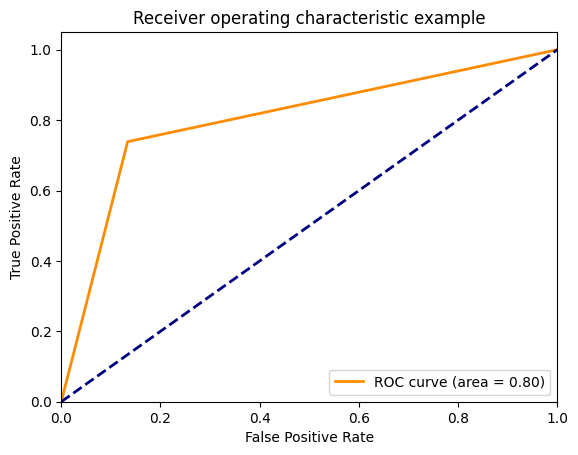

In [10]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Conclusió

En aquesta activitat hem vist algunes de les mètriques més utilitzades en els problemes de classificació. Utilitzar-ne una o una altra dependrà en bona mesura d'entendre quin és l'objectiu del problema.

<!--Footer-->
 <div style="background: #333333;padding: 35px 0px;margin-top: 25px;">
    <div class="row">
     <div class="col-sm-12">
        <img src="https://cv.uoc.edu/mc-icons/inici/logoUOC.png" alt="Logo UOC" class="img-responsive" style="margin: 0 auto; display: block;">
    </div>
</div>
</div>
<!--/Footer-->